# 개념도

- Ref: https://cpm0722.github.io/pytorch-implementation/transformer
- Transformer 개괄적 구조 및 역할
 * Seq 형태의 input을 사용해 seq 형태의 ouput을 만들어내는 함수

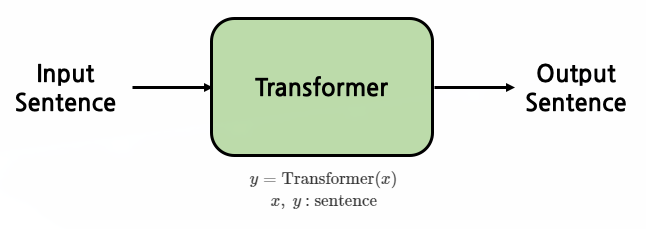

- Encoder의 개괄적 구조 및 역할
 * Seq 를 input으로 받아와 하나의 vector 생성
 * 이 때 Vector는 context라고 부르는데, seq의 정보들을 빠뜨리지 않고 압축하는 것을 목표로 학습
 
 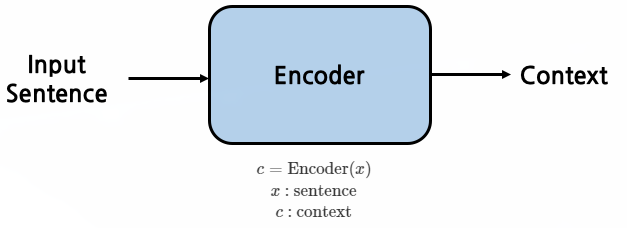
 
- Decoder의 개괄적 구조 및 역할
 * Seq를 right shift한 seq와 vector (context) 를 input으로 받아와 ouput 생성 
 
 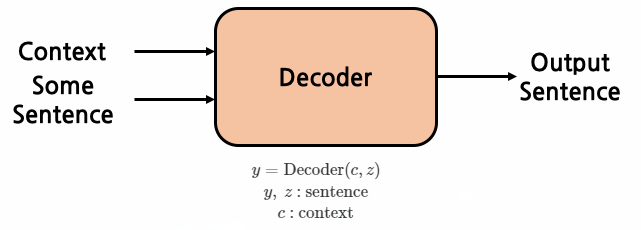
 

# 코딩

## Transformer model

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
#     def forward(self, x, z):
#         c = self.encoder(x)
#         y = self.decoder(z, c)
#         return z

    def forward(self, src, trg, src_mask, trg_mask): 
        # src_mask: encoder에서 사용하는 pad mask
        # trg_mask: decoder에서 사용하는 subsequent mask
        encoder_output = self.encoder(src, src_mask) 
        out = self.decoder(trg, trg_mask, encoder_output)
        return out        

## Encoder
- Encoder의 구조 및 내용
 * Encoder layaer가 N개 쌓여진 형태
 * Encoder layer를 겹겹이 쌓은 이유는 높은차원 (넓은관점)에서의 context를 담기 위함임 
 * 첫번째 encoder layer의 input은 encoder input으로 들어오는 문장 embedding 
 * 각 encoder layer의 input과 output shape 동일 
 * context는 input sentence와 동일한 shape

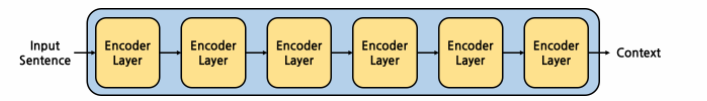

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoder_layer, n_layer): # n_layer: Encoder Layer의 개수
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_layer))
            
    def forward(self, x, mask):
        out = x
        for layer in self.layer:
            out = layer(out, mask)
        return out

### Encoder layer
- Encoder layer는 Multi-Head Attention Layer, Position-wise Feed-Forward Layer로 구성

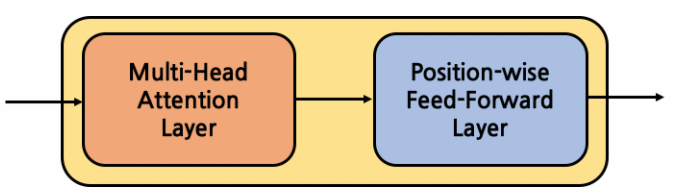
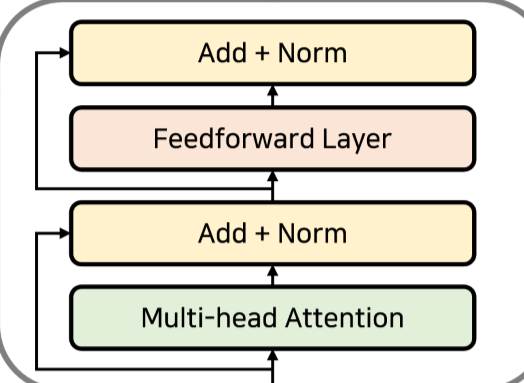

In [ ]:
class EncoderLayer(nn.Module):
    
    def __init__(self, multi_head_attention_layer, position_wise_feed_forward_layer, norm_layer):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention_layer = multi_head_attention_layer
        self.position_wise_feed_forward_layer = position_wise_feed_forward_layer
        self.residual_connection_layers = [ResidualConnectionLayer(copy.deepcopy(norm_layer)) for i in range(2)] 
        # norm_layer가 0번째는 Multi-head_attention_layer를 감싸고, 1번째는 position_wise_feed_forward_layer 감쌈
        
    def forward(self, x, mask):
        out = self.residual_connection_layer[0](x, lambda x: self.multi_head_attention_layer(x, x, x, mask))         
        out = self.residual_connection_layer[1](x, lambda x: self.position_wise_feed_forward_layer(x))
        return out        

### Self-Attention
- 개념: 같은 문장 내에서 두 token 사이의 연관성을 찾아내는 방법론 
 * self가 붙는 이유: 문장 내에서 같은 문장 내 다른 token에 대한 attention을 구하기 때문 
 * 개념예시: "The animal didn’t cross the street, because it was too tired." 에서 it이 가리키는 것을 학습하기 위함 
  
- RNN 대비 self-attention의 장점
 * 병렬처리 가능
    * RNN: hidden state hi를 구하기 위해선 앞에서부터 순차계산 필요 
    * self-attention:  모든 token 쌍 사이의 attention을 한 번의 행렬곱으로 구함
 * token들 사이의 명확한 관계 계산가능
    * RNN: 타임스텝 진행될 수록 오래된 시점의 token 정보 희미해져, 서로 거리가 먼 token 사이의 관계에 대한 정보 반영이 제대로 안됨
    * self-attnetion: 문장에 token이 n개 있을 경우, n x n 번 연산을수행해 모든 token들 사이의 관계를 직접 구함         
    
- Query, Key, Value
 * Query는 고정되어 하나의 token을 가르키고 (Ex. it), attention이 높은 token을 찾기 위해 key, value를 처음부터 끝까지 탐색
 * Query에 대한 attention을 구하는 개념 (Query's attention) 
 * 서로 다른 3개의 FC layer를 활용해 Q,K,V 구하며, 이 떄의 layer들은 모두 같은 shape
     * Query FC 계산 (Key, Value 과정 동일)
 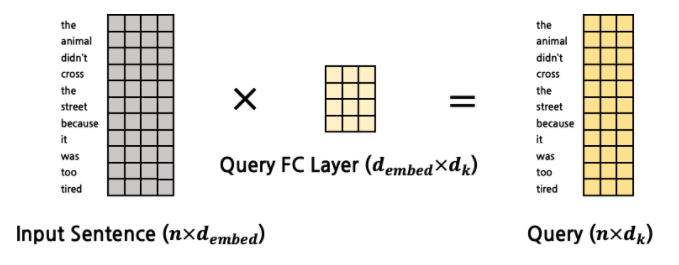 
  
- Pad masking    
 * 미니 배치 내 token 개수의 최대값 (seq_len)이 지정되어있고, 문장마다 token 개수가 달라 빈 token (pad token)이 있음
 * pad token들에 대하여 attention이 부여되지 않도록 처리
 * Q,K 행렬곱 이후, softmax 이전에 적용되어야 함
    * Q,K행렬곱 연산 이후 mask matric의 shape이 같아짐 (seq_len x seq_len)
    * 확률값 계산하는 soft max에 pad token 값이 반영되면 안되므로 softmax 이전에 masking 수행   

- Attention 계산 
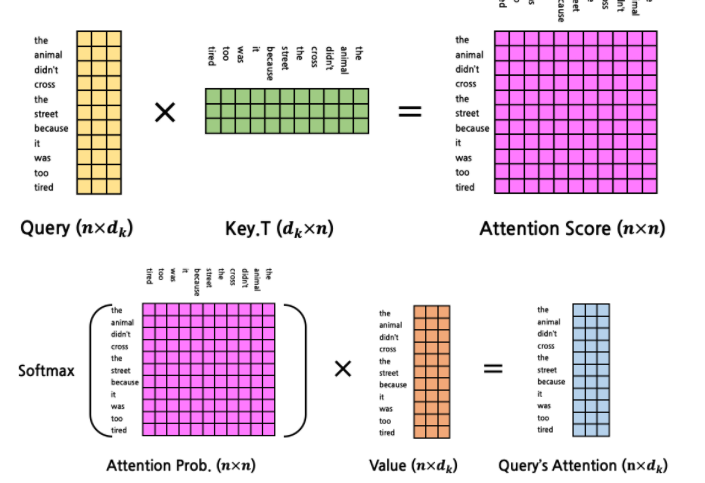
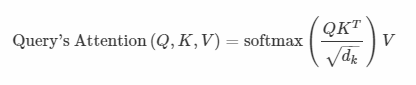
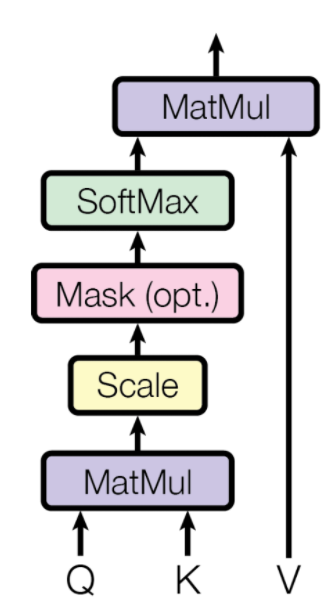

In [ ]:
def calculate_attention(self, query, key, value, mask):
    # query, key, value's shape: (n_batch, seq_len, d_k)
    d_k = key.size(-1) # get d_k
    attention_score = torch.matmul(query, key.transpose(-2, -1)), # Q x K^T, shape: (n_batch, seq_len, seq_len)
    attention_score = attention_score / math.sqrk(d_k) # scaling
    if mask is not None:
        attention_score = score.masked_fill(mask==0, -1e9) # masking
    attention_prob = F.softmax(score, dim=-1) # softmax, shape: (n_batch, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # shape: (n_batch, seq_len, d_k)
    return out

### Multi-Head Attention
- 개념적 접근
 * Multi-Head attention은 Scaled Dot-Product Attention을 한 Encoder Layer마다 h 회 수행한뒤, 그 결과를 종합하여 사용
 * 이유는 여러 attention을 잘 반영하기 위함
     * 예시: 하나의 attention만 반영 시 문장에서 "it"의 attention에는 "animal"의 것이 대부분 차지, but 여러 attention을 반영하면, 'animal'을 지칭하는 정보, 'tired'상태라는 정보까지 모두 담을 수 있음              
 * h개의 n*dk matrix를 모두 concatenate 하여 n*(dk*h) shape를 갖는 matrix (dk*h = dmodel)
 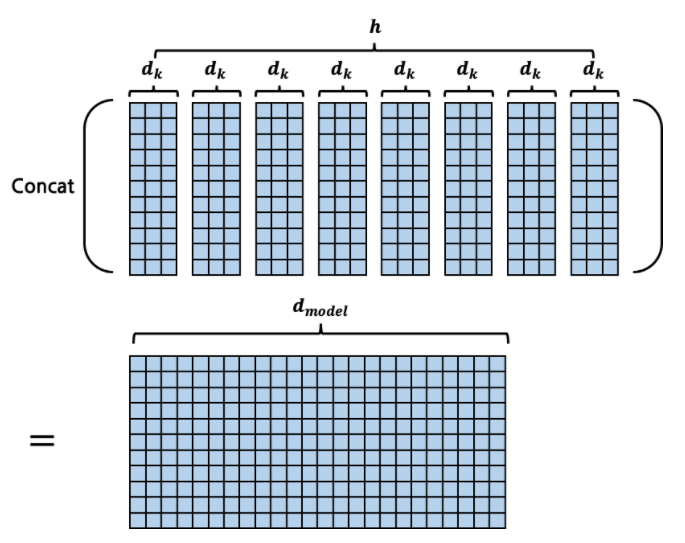
 
- 병렬처리 효율성 강화방법
 * 위의 방법은 Q, K, V로 각각의 self-attention을 계산해 concatenate하는 방식은 별개의 self-attention연산을 h회 수행해야함
 * 아이디어: Q, K, V 자체를 n x d_k 가 아닌 d x d_model 로 생성해서 한번의 self-attention 계산
 
 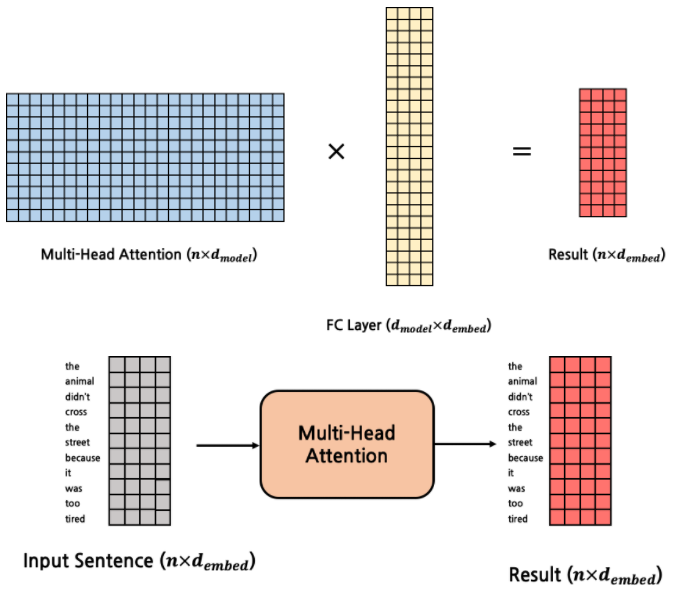

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h, qkv_fc_layer, fc_layer):
        # qkv_fc_layer: (d_embeded, d_model)
        # fc_layer: (d_model, d_embeded)
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        sellf.h = h
        self.query_fc_layer = copy.deepcopy(qkv_fc_layer)
        self.key_fc_layer = copy.deepcopy(qkv_fc_layer)
        self.value_fc_layer= copy.deepcopy(qkv_fc_layer)
        self.fc_layer = fc_layer #attention 계산 이후 거쳐가는 layer로, d_model x d_embeded
        
    def forward(self, query, key, value, mask=None):
        # Q, K, V: (n_batch, seq_len, d_embeded)
        # mask: (n_batch, seq_len, seq_len)
        n_batch = query.shape[0] # get n_batch 
        
        def transform(x, fc_layer): # reshape이유: calculate_attention() shape맞추기위함 (n_batch, seq_len, d_embeded) to (n_batch, h, seq_len, d_k)
            out = fc_layer(x) # out: (n_batch, seq_len, embeded)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # out: (n_batch, seq_len, h, d_k)
            out = out.transpose(1,2) # out: (n_batch, h, seq_len, d_k)
            return out
        
        query = transform(query, self.query_fc_layer)
        key = transform(key, self.key_fc_layer)
        value = transform(key, self.value_fc_layer)
        
        if mask is not None:
            mask = mask.unsqueeze(1) # mask: (n_batch, 1, seq_len, seq_len), reshape: calculation_attention()내에서 broadcasting 제대로 수행하기 위함
            
        out = self.calculation_attention(query, key, value, mask) # out: (n_batch, h, seq_len, d_k)
        out = out.transpose(1,2) # out: (n_batch, seq_len, h, d_k)
        out = contiguous().view(n_batch, -1, self.d_moel) # h와 d_k 결합, out: (n_batch, seq_len, d_model)
        out = self.fc_layer(out) # out: (n_batch, seq_len, d_embeded)
            
            

### Position-wise Feed Forward Layer
- 2개의 FC layer를 갖는 layer
- 각 FC layer는 (d_embed, d_ff), (dff, d_embed)의 weight matrix
- FFN(x) = max(0, xW1+b1)W2 + b2 : 첫번째 FC layer의 output에 Relu 적용과 동일의미

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, first_fc_layer, second_fc_layer):
        self.first_fc_layer = first_fc_layer
        self.second_fc_layer = second_fc_layer
        
    def forward(self, x):
        out = self.first_fc_layer(x)
        out = F.lelu(out)
        out = self.dropout(out)
        out = self.second_fc_layer(out)
        return out
    

### Residual connection + Norm layer
- Residual connection이란: y = f(x) 를 y = f(x) +x 로 변경하는 것
 * 사용목적: back propagation 중 발생할 수 있는 gradient vanishing 방지
- Layer normalization: 비슷한 목적

In [ ]:
class ResidualConnectionLayer(nn.Module):
    def __init__(self, norm_layer):
        super(ResidualConnectionLayer, self).__init__()
        self.norm_layer = norm_layer
        
    def forward(self, x, sub_layer):
        out = sub_layer(x) + x
        out = self.norm_layer(out)
        return out        

## Decoder
- Input
 * Context: Encoder에서 생성된 것
 * Sentence
     * Teacher forcing in transforemr (subsequent masking)
         * Labeld data (ground trunth)를 input으로 사용
         * 학습과정에서 모델이 잘못된 token을 생성해내더라도 제대로 된 token을 생성해내도록 유도 (NLP에서 필수적)
- Teacher forcing (subsequent masking) 구현
 * Subsequent masking 활용 
 * RNN과 달리 병렬연산이므로 i번째 token을 생성해 낼 때, 1~i-1의 token은 보이지 않도록 처리         

In [ ]:
def subsequent_mask(size):
    atten_shape = (1, size, size)
    mask = np.triu(np.ones(atatn_shape), k=1).astype('uint8') # masking with upper triangle matrix
    return torch.from_numpy(mask)==0 # reverse (masking=False, non-masking=True)

def make_std_mask(tgt, pad):
    tgt_mask = (tgt!=pad) # pad masking
    tgt_mask = tgt_mask.unsqueeze(-2) # reshape (n_batch, seq_len) -> (n_batch, 1, seq_len)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)) # pad_masking & subsequent_masking
    return tgt_mask